## Градиентный спуск

- Выбрать тестовые функции оптимизации (2 шт)
- Запрограммировать собственнуб реализацию классического градиентного спуска
- Запрограммировать пайлайн тестирования алгоритма оптимизации
  - Визуализации функции и точки оптимума
  - Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
  - Визуализации точки найденного решения (можно добавить анимацию на плюс балл)
- Запрограммировать метод вычисления градиента
  - Передача функции градиента от пользователя
  - Символьное вычисление градиента (например с помощью sympy) (на доп балл)
  - Численная аппроксимация градиента (на доп балл)
- Запрограммировать одну моментную модификацию и протестировать ее
- Запрограммировать одну адаптивную модификацию и протестировать ее
- Запрограммировать метод эволюции темпа обучения и/или метод выбора начального приближения и протестировать их

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

## 0. Тестовые функции

In [2]:
def Matyas(value: np.array):
  x, y = value
  return 0.26 * (x**2 + y**2) - 0.48 * x * y

def Matyas_grad(value: np.array):
  x, y = value
  return np.array([0.52 * x - 0.48 * y, 0.52 * y - 0.48 * x])

In [3]:
def Booth(value: np.array):
  x, y = value
  return (x + 2 * y - 7)**2 + (2 * x + y - 5)**2

def Booth_grad(value: np.array):
  x, y = value
  return np.array([2 * (x + 2 * y - 7) + 4 *(2 * x + y - 5),
                  4 * (x + 2 * y - 7) + 2 * (2 * x + y - 5)])

## Визуализация & анимация


In [4]:
def visualize(f: callable, bounds: np.array, history: np.array, glob_min: np.array, title: str):
  """
  f - function
  bounds - bounds
  history - history of descent
  glob_min - global minimum
  title - title
  """
  fig = plt.figure(figsize = (10, 10))
  ax = plt.axes(projection='3d')
  x = np.linspace(bounds[0, 0], bounds[1, 0], 100)
  y = np.linspace(bounds[0, 1], bounds[1, 1], 100)
  x, y = np.meshgrid(x, y)

  z = f(np.array([x, y]))
  ax.plot_surface(x, y, z, cmap='Spectral', edgecolor='none', alpha=0.6)
  ax.plot(history[:, 0], history[:, 1], history[:, 2], '-', c='black', alpha = 1)
  ax.scatter(history[0, 0], history[0, 1], history[0, 2], lw=2, color='green', s=50, alpha = 1, label='Начальная точка')
  ax.scatter(history[-1, 0], history[-1, 1], history[-1, 2], lw=1, color='yellow', s=50, alpha = 1, label='Найденный минимум')
  ax.scatter(glob_min[0], glob_min[1], glob_min[2], lw= 1, s=250,  color='white', ec='black', alpha = 0.6, marker = 'X', label='Глобальный минимум')
  ax.legend(fontsize=12, loc='upper left')
  ax.set_title(title, loc='left')
  ax.set_xlabel('x', fontsize=12)
  ax.set_ylabel('y', fontsize=12)
  ax.set_zlabel('z', fontsize=12)
  np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
  print(f"Начальная точка: {history[0]}")
  np.set_printoptions(formatter={'float_kind':"{:.2e}".format})
  print(f"Найденный минимум: {history[-1]}")
  plt.show()

In [5]:
def animate(f, h1, h2, h3, h4, min, title):
  """
  f - function
  h1 - history for gd method
  h2 - history for momentum modification
  h3 - history for adaptive modification
  h4 - history for gd with evolution lr
  min - global minimum
  title - title
  """
  x = np.linspace(-10, 10, 100)
  y = np.linspace(-10, 10, 100)
  x, y = np.meshgrid(x, y)
  z = f(np.array([x, y]))

  fig, ax = plt.subplots(1, 1)
  ax.contour(x, y, z)
  plt.xlim(-11, 11)
  plt.ylim(-11, 11)
  graph1, = plt.plot([], [], 'o', c='blue', label='GD')
  graph2, = plt.plot([], [], '>', c='orange', label='Momentum GD')
  graph3, = plt.plot([], [], 'x', c='purple', label='ADAM')
  graph4, = plt.plot([], [], '*', c='g', label='Evolution of lr')
  L = plt.legend(loc=1)
  plt.title(title)
  ax.set_xlabel('x', fontsize=16)
  ax.set_ylabel('y', fontsize=16)
  x_min, y_min = min
  red_dot = plt.plot(x_min, y_min, '^', lw = 1, color='white', mec='red', label='Глобальный минимум')
  plt.close()

  def animate(i):
      graph1.set_data([h1[i][0]], [h1[i][1]])
      graph2.set_data([h2[i][0]], [h2[i][1]])
      graph3.set_data([h3[i][0]], [h3[i][1]])
      graph4.set_data([h3[i][0]], [h4[i][1]])
      return graph1, graph2, graph3, graph4

  return FuncAnimation(fig, animate, frames=len(h3), interval=200, repeat=False)

## Градиентный спуск

In [6]:
def gradient_descent(f: callable, gradient: callable, start_point: np.array, lr: float, num_iter: int):

  """
  f - function
  grad - gradient
  start_point - start
  lr - learning rate
  iter - number of iterations
  """

  hist = [np.array([start_point[0].copy(), start_point[1].copy(), f(start_point)])]
  pos = start_point.copy()

  for i in range(num_iter):
    pos = pos - lr * gradient(pos)
    hist.append(np.array([pos[0], pos[1], f(pos)]))

  return np.array(hist)

Начальная точка: [10.00 -10.00 100.00]
Найденный минимум: [7.06e-09 -7.06e-09 4.98e-17]


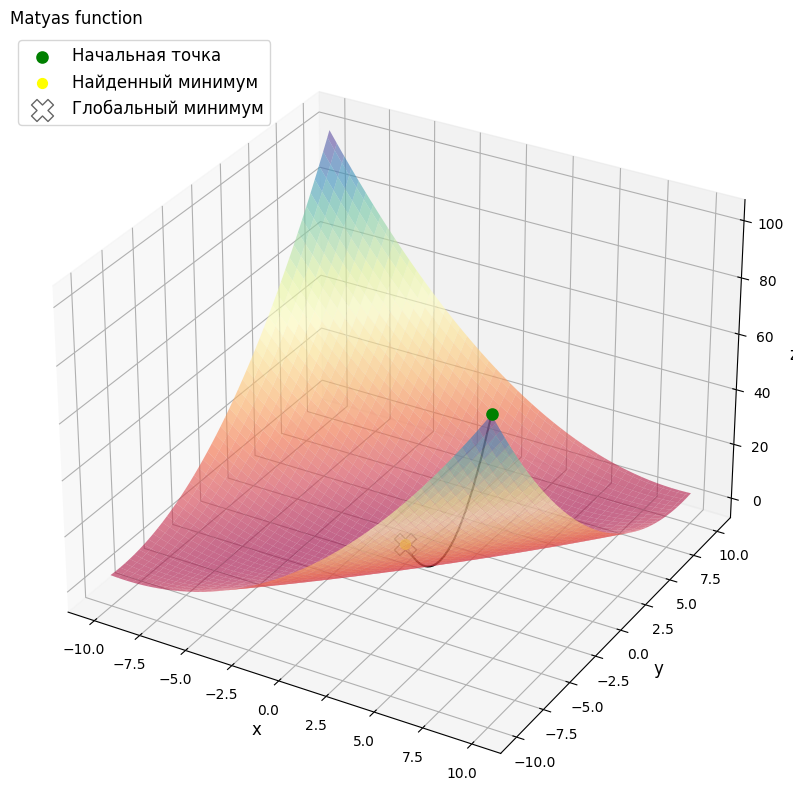

In [7]:
start_point_Matyas = np.array([10, -10])
M_hist1 = gradient_descent(Matyas, Matyas_grad, start_point_Matyas, 0.1, 200)
visualize(Matyas, np.array([[-10, -10], [10, 10]]), M_hist1, np.array([0., 0., 0.]), 'Matyas function')

Начальная точка: [10.00 10.00 1154.00]
Найденный минимум: [1.00e+00 3.00e+00 3.37e-09]


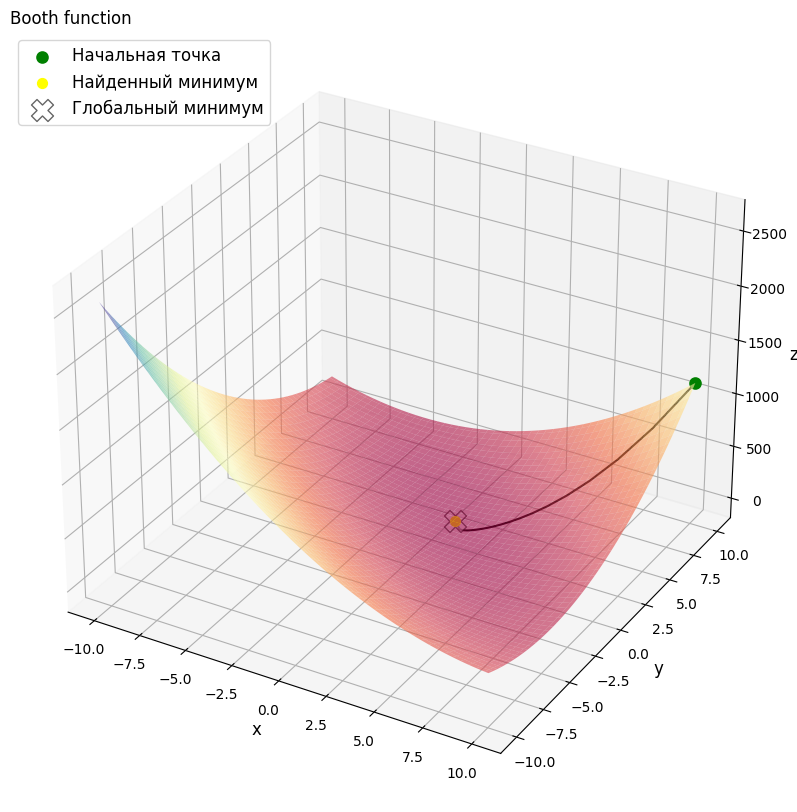

In [8]:
start_point_Booth = np.array([10, 10])
B_hist1 = gradient_descent(Booth, Booth_grad, start_point_Booth, 0.01, 500)
visualize(Booth, np.array([[-10., -10.], [10., 10.]]), B_hist1, np.array([1., 3., 0.]), 'Booth function')

## Моментная модификация

In [9]:
def momentumGD(f: callable, gradient: callable, start_point: np.array, lr: float, nu: float, num_iter: int):
  """
  f - function
  grad - gradient
  start_point - start point
  lr - learning rate
  nu - parameter
  num_iter - number of iterations
  """

  hist = [np.array([start_point[0].copy(), start_point[1].copy(), f(start_point)])]
  params = start_point.copy()
  params_prev = start_point.copy()

  for i in range(num_iter):
    params_new = params - lr * gradient(params) + nu * (params - params_prev)
    params_prev = params
    params = params_new

    hist.append(np.array([params[0], params[1], f(params)]))

  return np.array(hist)

Начальная точка: [10.00 -10.00 100.00]
Найденный минимум: [-9.50e-30 9.50e-30 9.02e-59]


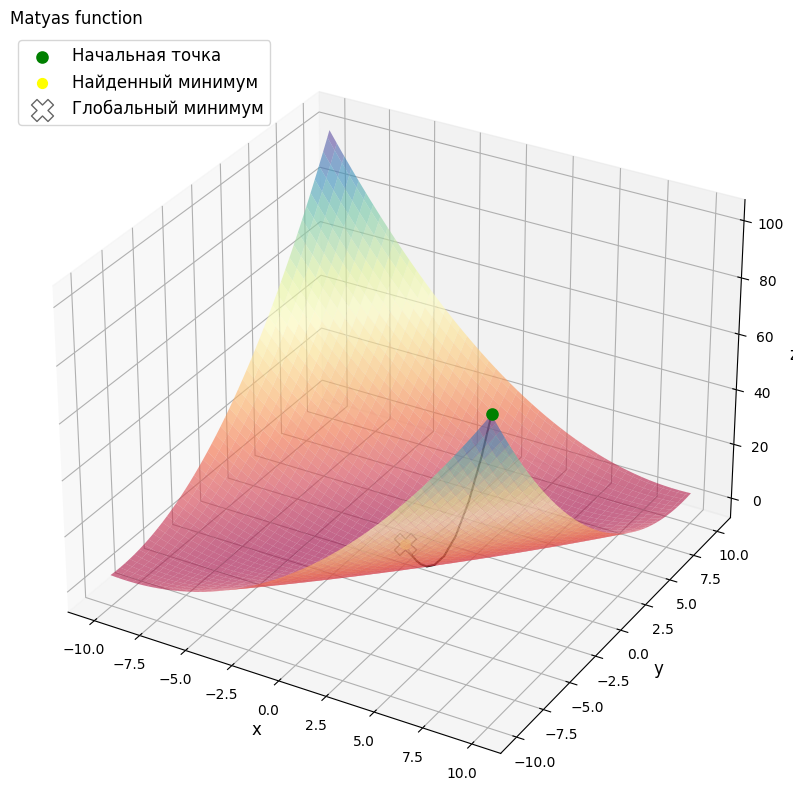

In [10]:
M_hist2 = momentumGD(Matyas, Matyas_grad, start_point_Matyas, 0.1, 0.5, 200)
visualize(Matyas, np.array([[-10, -10], [10, 10]]), M_hist2, np.array([0., 0., 0.]), 'Matyas function')

Начальная точка: [10.00 10.00 1154.00]
Найденный минимум: [1.00e+00 3.00e+00 1.73e-15]


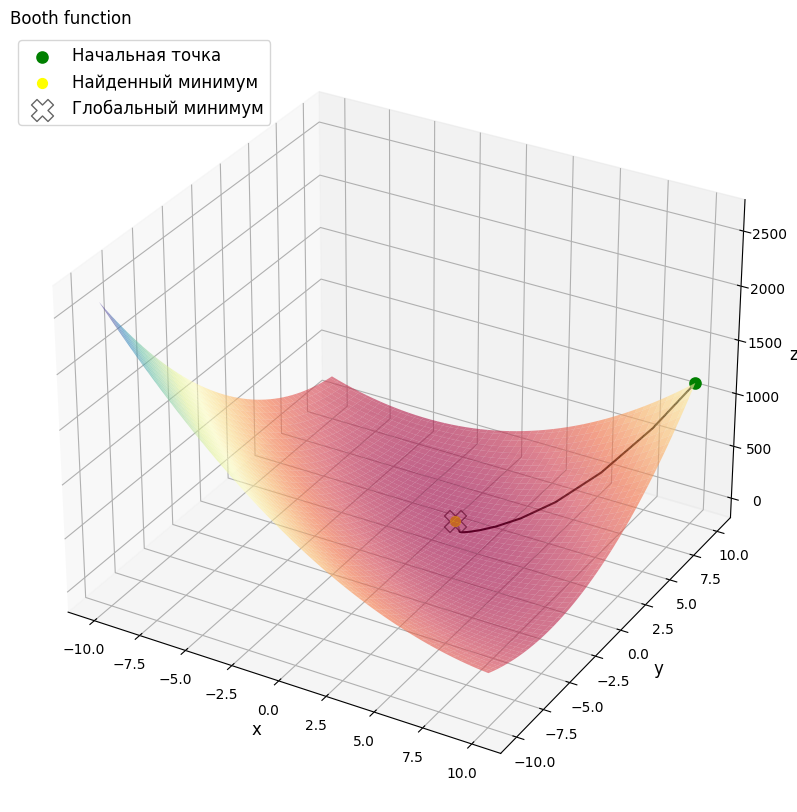

In [11]:
B_hist2 = momentumGD(Booth, Booth_grad, start_point_Booth, 0.01, 0.4, 500)
visualize(Booth, np.array([[-10., -10.], [10., 10.]]), B_hist2, np.array([1., 3., 0.]), 'Booth function')

### Адаптивная модификация

In [12]:
def adaptive_gd(f: callable, gradient: callable, start_point: np.array, lr: float, beta1: float, beta2: float,
                num_iter: int, eps: float=10e-8):
    """
    f - function
    grad - gradient
    start_point - start point
    lr - learning rate
    beta1 - first parametr
    beta2 - second parameter
    num_iter - number of iterations
    """

    hist = [np.array([start_point[0].copy(), start_point[1].copy(), f(start_point)])]
    pos = start_point.copy()
    m = np.array([0, 0])
    v = np.array([0, 0])

    for i in range(num_iter):
      m = beta1 * m + (1 - beta1) * gradient(pos)
      v = beta2 * v + (1 - beta2) * gradient(pos) ** 2
      pos = pos - lr * m / (np.sqrt(v) + eps)
      hist.append(np.array([pos[0], pos[1], f(pos)]))

    return np.array(hist)

Начальная точка: [10.00 -10.00 100.00]
Найденный минимум: [4.60e-09 -4.60e-09 2.12e-17]


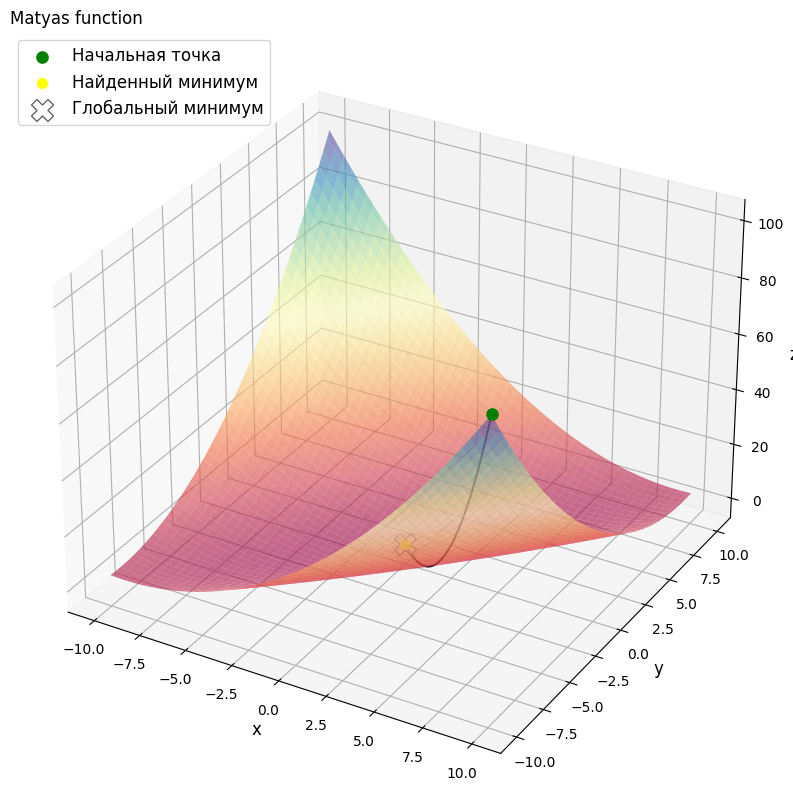

In [13]:
M_hist3 = adaptive_gd(Matyas, Matyas_grad, start_point_Matyas, 0.1, 0.6, 0.9, 200)
visualize(Matyas, np.array([[-10, -10], [10, 10]]), M_hist3, np.array([0., 0., 0.]), 'Matyas function')

Начальная точка: [10.00 10.00 1154.00]
Найденный минимум: [1.01e+00 3.01e+00 2.02e-03]


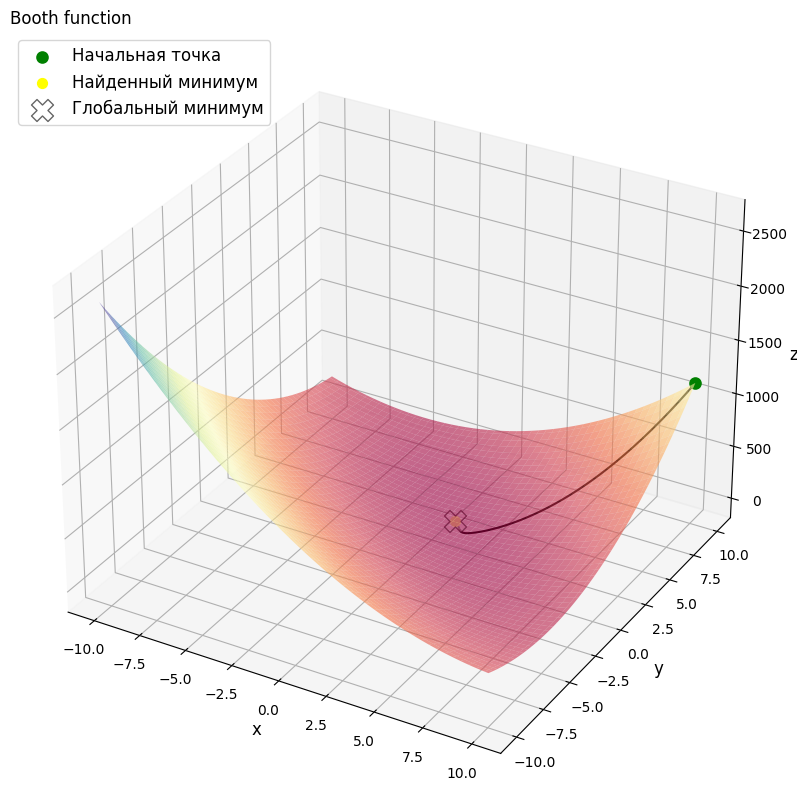

In [14]:
B_hist3 = adaptive_gd(Booth, Booth_grad, start_point_Booth, 0.1, 0.6, 0.9, 500)
visualize(Booth, np.array([[-10., -10.], [10., 10.]]), B_hist3, np.array([1., 3., 0.]), 'Booth function')

## ГС с эволюцией темпа обучения

In [15]:
def changing_lrGD(f: callable, gradient: callable, start_point: np.array, divider: int, lr: float, num_iter: int):

  """
  f - function
  grad - gradient
  start_point - start
  divider - coefficient
  lr - learning rate
  iter - number of iterations
  """

  hist = [np.array([start_point[0].copy(), start_point[1].copy(), f(start_point)])]
  pos = start_point.copy()

  for i in range(num_iter):
    if i % 40 == 0 and i > 0:
      lr = lr / divider
    pos = pos - lr * gradient(pos)
    hist.append(np.array([pos[0], pos[1], f(pos)]))

  return np.array(hist)

Начальная точка: [10.00 -10.00 100.00]
Найденный минимум: [2.00e-02 -2.00e-02 3.99e-04]


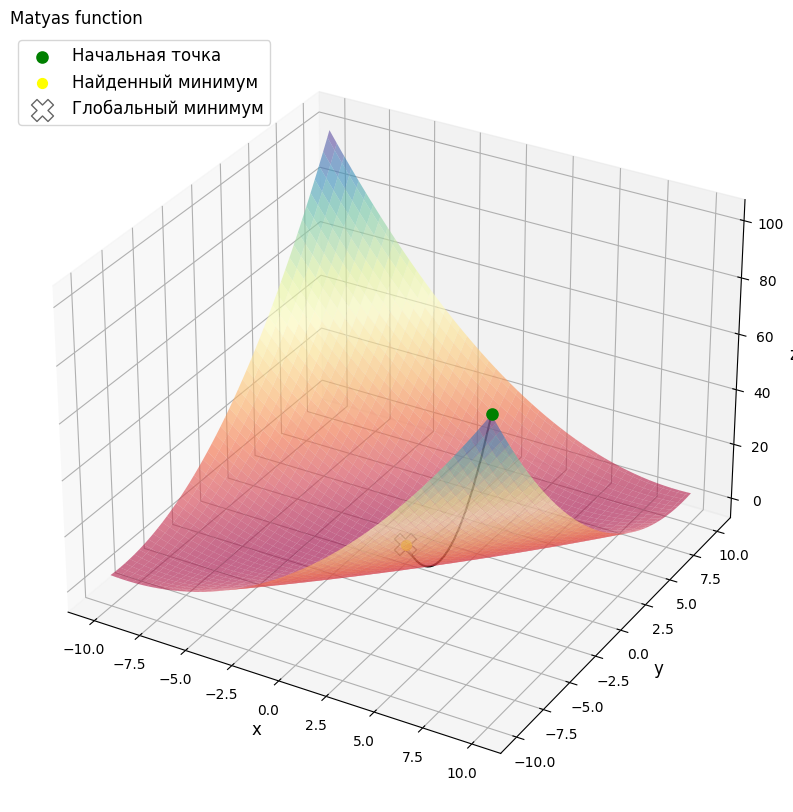

In [16]:
M_hist4 = changing_lrGD(Matyas, Matyas_grad, start_point_Matyas, 3, 0.1, 200)
visualize(Matyas, np.array([[-10, -10], [10, 10]]), M_hist4, np.array([0., 0., 0.]), 'Matyas function')

Начальная точка: [10.00 10.00 1154.00]
Найденный минимум: [1.01e+00 2.99e+00 1.11e-04]


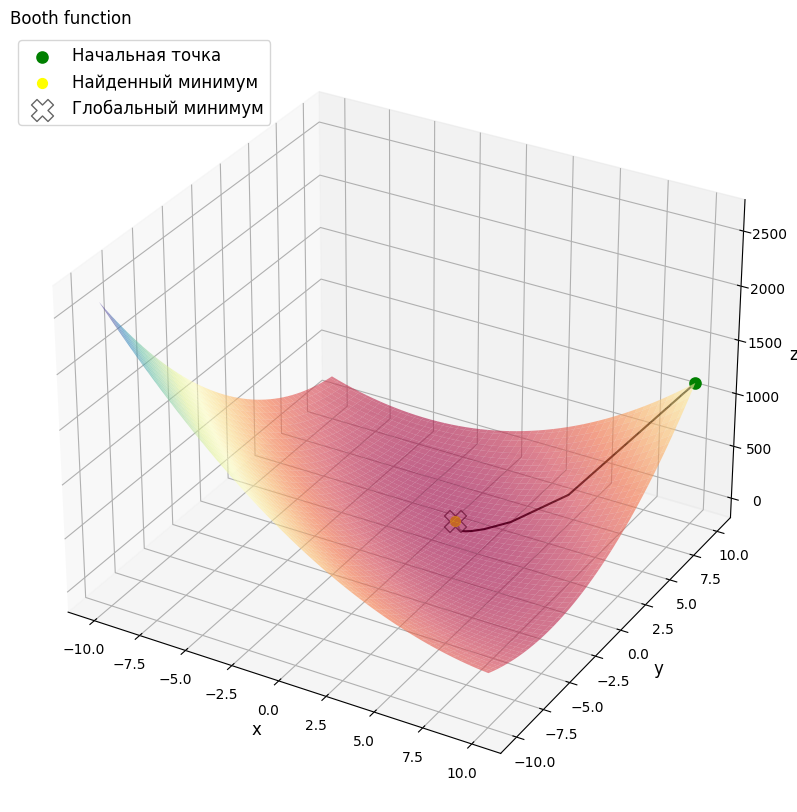

In [17]:
B_hist4 = changing_lrGD(Booth, Booth_grad, start_point_Booth, 2, 0.03, 500)
visualize(Booth, np.array([[-10., -10.], [10., 10.]]), B_hist4, np.array([1., 3., 0.]), 'Booth function')

### Animation

In [18]:
ani = animate(Matyas, M_hist1, M_hist2, M_hist3, M_hist4, (0, 0), 'Matyas function')
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [19]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
ani = animate(Booth, B_hist1, B_hist2, B_hist3, B_hist4, (1, 3), 'Booth function')
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# ani.save('/content/drive/MyDrive/0 MAI/maga/1 sem/ML/Bobr/1/Matyas_animation.gif',  dpi=300, writer=PillowWriter(fps=25))